In [1]:
import os
from sys import platform
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
from monai.config import print_config
from monai.data import DataLoader, decollate_batch, CacheDataset
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet, SegResNetVAE
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)
from monai.utils import set_determinism

import torch

from utils.utils import make_dataset, train_test_splitting, get_device, get_slice, get_brats_classes
from utils.plotting import plot_input_output
import random

print_config()

MONAI version: 1.3.0
Numpy version: 1.23.5
Pytorch version: 2.3.0.dev20240314
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.13
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.21.0
scipy version: 1.10.1
Pillow version: 10.2.0
Tensorboard version: 2.15.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.18.0.dev20240314
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.0.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.30.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about i

In [2]:
set_determinism(seed=3)
random.seed(3)

In [3]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
	"""
	Convert labels to multi channels based on BraTS-2023 classes:
		- label 1 (NCR): the necrotic tumor core
		- label 2 (ED): the peritumoral edematous/invaded tissue
		- label 3 (ET): the GD-enhancing tumor
	The sub-regions considered for evaluation are:
		- "enhancing tumor" (ET)
		- "tumor core" (TC)
		- "whole tumor" (WT)
	"""
	def __call__(self, data):
		d = dict(data)
		for key in self.keys:
			result = []
			# label 3 is ET
			result.append(d[key] == 3.)
			# merge label 1 and label 3 to construct TC
			result.append(torch.logical_or(d[key] == 1., d[key] == 3.))
			# merge labels 1, 2 and 3 to construct WT
			result.append(torch.logical_or(torch.logical_or(d[key] == 2., d[key] == 3.), d[key] == 1.))
			d[key] = torch.stack(result, axis=0).float()
		return d

In [4]:
train_transform = Compose(
    [
        LoadImaged(keys=['image', 'label']),
        EnsureChannelFirstd(keys='image'),
        EnsureTyped(keys=['image', 'label']),
        ConvertToMultiChannelBasedOnBratsClassesd(keys='label'),
        Orientationd(keys=['image', 'label'], axcodes='RAS'), #(Left, Right),(Posterior, Anterior),(Inferior, Superior)
        Spacingd(
            keys=['image', 'label'],
            pixdim=(1.0, 1.0, 1.0),
            mode=('bilinear', 'nearest'),
        ),
        RandSpatialCropd(keys=['image', 'label'], roi_size=[224, 224, 144], random_size=False),
        RandFlipd(keys=['image', 'label'], prob=0.5, spatial_axis=0),
        RandFlipd(keys=['image', 'label'], prob=0.5, spatial_axis=1),
        RandFlipd(keys=['image', 'label'], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys='image', nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys='image', factors=0.1, prob=1.0),
        RandShiftIntensityd(keys='image', offsets=0.1, prob=1.0),
    ]
)
test_transform = Compose(
    [
        LoadImaged(keys=['image', 'label']),
        EnsureChannelFirstd(keys='image'),
        EnsureTyped(keys=['image', 'label']),
        ConvertToMultiChannelBasedOnBratsClassesd(keys='label'),
        Orientationd(keys=['image', 'label'], axcodes='RAS'),
        Spacingd(
            keys=['image', 'label'],
            pixdim=(1.0, 1.0, 1.0),
            mode=('bilinear', 'nearest'),
        ),
        NormalizeIntensityd(keys='image', nonzero=True, channel_wise=True),
    ]
)

In [5]:
data_path = make_dataset(dataset='glioma', verbose=False)
train_data, test_data = train_test_splitting(data_path)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

                    TRAINING            TESTING             

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

subjects            906 (80.0 %)        227 (20.0 %)        

sessions            1002 (80.1 %)       249 (19.9 %)        



In [6]:
train_ds = CacheDataset(train_data[:80], transform=train_transform, cache_rate=1.0, num_workers=None, progress=True)
test_ds = CacheDataset(test_data[:20], transform=test_transform, cache_rate=1.0, num_workers=None, progress=True)
print(f"Input image shape: {train_ds[0]['image'].shape}")
print(f"Input label shape: {train_ds[0]['label'].shape}")
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=0)

Loading dataset: 100%|██████████| 20/20 [00:03<00:00,  5.16it/s]


Input image shape: torch.Size([4, 224, 224, 144])
Input label shape: torch.Size([3, 224, 224, 144])


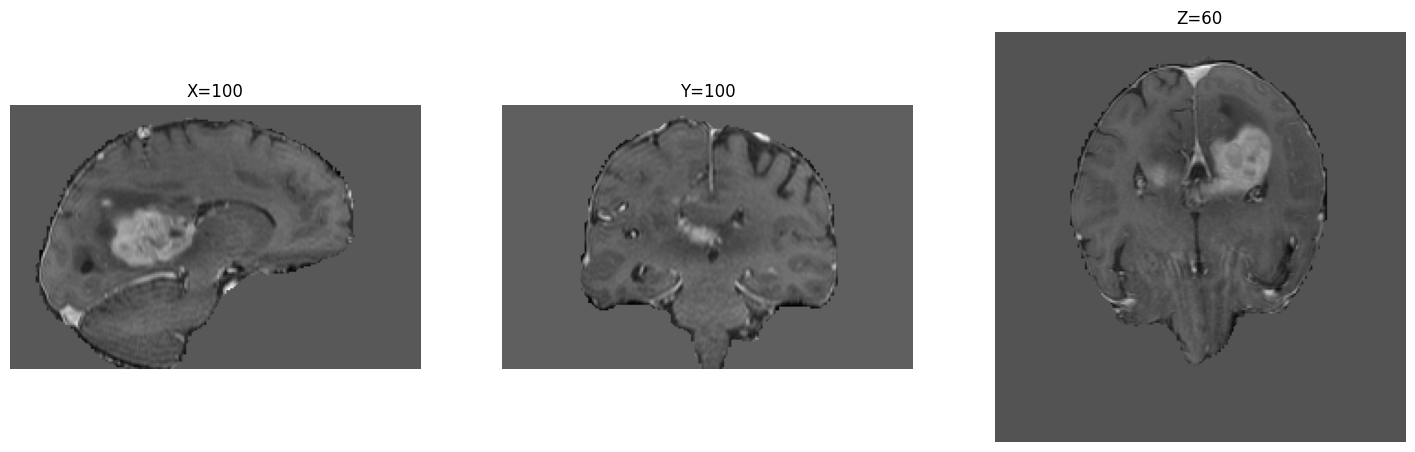

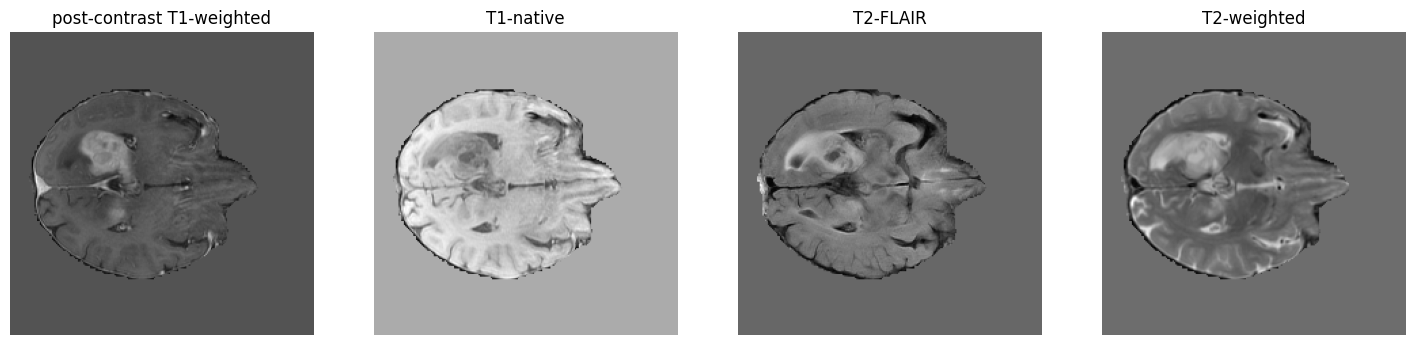

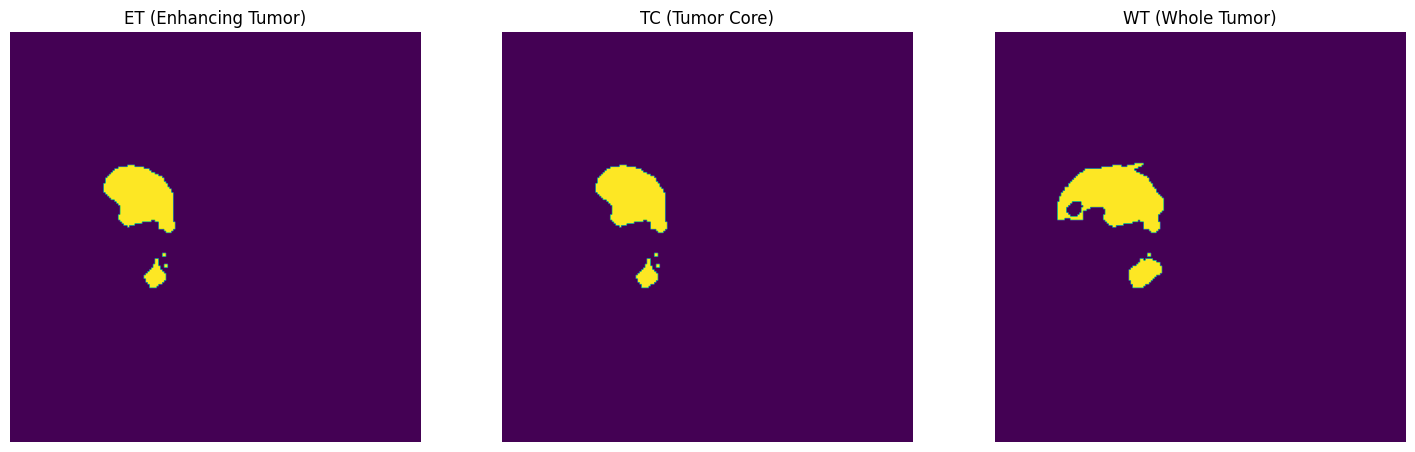

In [16]:
plot_input_output(train_ds[3])

In [11]:
max_epochs = 30
val_interval = 1
VAL_AMP = True

# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
device = torch.device('cpu')
model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=4,
    out_channels=3,
    dropout_prob=0.2,
).to(device)
loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")
post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

# define inference method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )
    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)

# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

In [12]:
_base_path = '\\'.join(os.getcwd().split('\\')[:-1]) + '\\' if platform == 'win32' else '/'.join(os.getcwd().split('/')[:-1]) + '/'
saved_path = os.path.join(_base_path, 'notebooks/saved')

In [ ]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_et = []
metric_values_tc = []
metric_values_wt = []

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in train_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_et = metric_batch[0].item()
            metric_values_et.append(metric_et)
            metric_tc = metric_batch[1].item()
            metric_values_tc.append(metric_tc)
            metric_wt = metric_batch[2].item()
            metric_values_wt.append(metric_wt)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(saved_path, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")